## Country-wise topic analysis

In [1]:
from distfit import distfit
from pyfiles.mod_topic_influence_base import *

In [2]:
%store -r group_publication_titles
# %store -r topic_with_value
# %store -r topic_rank
# %store -r norm_distance_kl
# %store -r norm_distance_tau
%store -r mgp_nodes

In [3]:
#group_publication_titles[258]

In [4]:
%store -r lda_model
%store -r id2word
%store -r prepare_text_for_lda

In [5]:
def country_wise_approach1(mgp_nodes, group_publication_titles, topic_rank_value):
    group_head_country = [mgp_nodes[mgp_nodes["Id"]==k]["Country"].values[0] 
                          for k,v in group_publication_titles.items() if len(v) > 0]
    top_topic_group_over_interval = [[topics[0] if topics[0]>0.0 else None for topics in intervals] 
                                     for intervals in topic_rank_value]
    top_topic_over_group = [(country, Counter(topics).most_common()[0][0]) 
                            for topics, country in zip(top_topic_group_over_interval,group_head_country)]
    country_score = {}
    for country, topic in top_topic_over_group:
        if country in country_score :
            country_score[country].append(topic)
        else:
            country_score[country] = []
            country_score[country].append(topic)
    country_score = [(country, Counter(country_score[country]).most_common()[0]) for country in country_score]
    country_freq  = Counter(group_head_country)
    country_publ_tuple = [(mgp_nodes[mgp_nodes["Id"]==k]["Country"].values[0], v) for k,v in group_publication_titles.items() if len(v) > 0]
    country_publ1 = {}
    for country, publ in country_publ_tuple:
        if country in country_publ1:
            country_publ1[country].extend(publ)
        else:
            country_publ1[country] = publ
    country_year = {country:[year for publ,year in country_publ1[country]] for country in country_publ1}
    country_yl = {country: max(country_year[country])-min(country_year[country]) for country in country_year}
    normalize_country_score =  [(key1, val1[1]/(country_yl[key1]*country_freq[key1])) for key1, val1 in country_score]
    sorted_normalize_country_score =  sorted(normalize_country_score, key= lambda x : x[1], reverse=True)
    return sorted_normalize_country_score

In [6]:
#score = country_wise_approach1(mgp_nodes, group_publication_titles, topic_rank)

In [7]:
#sorted_country_freq = sorted(country_freq.items(), key=lambda x: x[1], reverse=True)

In [8]:
#no_diff_topics = sorted(country_score, key= lambda x : x[1], reverse=True)

In [9]:
#top_topic_over_group = [(country, Counter(topics).most_common()[0][1]/len(topics)) for topics,country in zip(top_topic_group_over_interval,group_head_country)]

In [10]:
def country_wise_approach2(mgp_nodes, group_publication_titles):
    mgp_nodes["Country"] = mgp_nodes["Country"].fillna("")
    mgp_nodes  = mgp_nodes[~(mgp_nodes["Country"]=="")].copy()
    country_publ_tuple = [(mgp_nodes[mgp_nodes["Id"]==k]["Country"].values[0], v) 
                          for k,v in group_publication_titles.items() if len(v) > 0] 
    #check to not incluede missing country
    country_publ_tuple = [("",v)  if pd.isna(k) else (k,v) for k,v in country_publ_tuple]
    country_publ1 = {}
    
    for country, publ in country_publ_tuple:
        if country in country_publ1:
            country_publ1[country].extend(publ)
        else:
            country_publ1[country] = publ
    
    country_publ = {country:[publ for publ,year in country_publ1[country]] for country in country_publ1}
    country_year = {country:[year for publ,year in country_publ1[country]] for country in country_publ1}
    country_yl   = {country: max(country_year[country])-min(country_year[country])+1 for country in country_year}
    country_topic_dist  =  {country:predict(lda_model, id2word, prepare_text_for_lda, country_publ[country]) 
                            for country in country_publ}
    country_top_topic_over_groups = {country:[get_top_topic(topic) for topic in country_topic_dist[country]] 
                                     for country in country_topic_dist}
    country_top_topic = {country:Counter(country_top_topic_over_groups[country]).most_common()[0] 
                        for country in country_top_topic_over_groups}
    normalized_score  = {country:country_top_topic[country][1]/country_yl[country] 
                        for country in country_top_topic}
    sorted_normalized_score =  sorted(normalized_score.items(), key=lambda x:x[1], reverse=True)
    return (sorted_normalized_score, country_top_topic_over_groups)

In [11]:
def country_wise_approach3(mgp_nodes, group_publication_titles):
    global lda_model
    global id2word
    global prepare_text_for_lda
    Min_publ=0
#     lda_model, id2word = load_topic_model(topic_model, topic_dict, corpus)
#     lda_model.minimum_probability = 0.0
    num_topics = lda_model.num_topics
    mgp_nodes["Country"] = mgp_nodes["Country"].fillna("not_aval")
    #mgp_nodes  = mgp_nodes[~(mgp_nodes["Country"]=="")].copy()
#     county_publ_tuple = [(mgp_nodes[mgp_nodes["Id"]==k]["University"].values[0].split(" and "), v) for k,v in group_publication_titles.items() if len(v) > Min_publ]
    county_publ_tuple = [(mgp_nodes[mgp_nodes["Id"]==k]["Country"].values[0], v) for k,v in group_publication_titles.items() if (len(v) > Min_publ and mgp_nodes[mgp_nodes["Id"]==k]["Country"].values[0]!="")]
    #county_publ_tuple = [(sublist,v) for k,v in county_publ_tuple for sublist in k]
    county_publ1 = {}
    for county, publ in county_publ_tuple:
        if county in county_publ1:
            county_publ1[county].extend(publ)
        else:
            county_publ1[county] = publ
    #del county_publ1["Business"]F
    county_year = {county:[year for publ,year in county_publ1[county]] for county in county_publ1}
    country_publ = {country: [(" ".join([publ for publ, year in county_publ1[country] if yr==year]),yr) for yr in sorted(set(county_year[country]))] for country in county_publ1}
    country = [k for k,v in country_publ.items() if len(v) > Min_publ]
    topic_distribution_year = [(topic_distributions_over_interval((k,v), lda_model, id2word,prepare_text_for_lda)) 
                               for k,v in country_publ.items() if len(v) > Min_publ]
    interval_start_year = [i[0] for i in topic_distribution_year]
    topic_distribution  = [i[1] for i in topic_distribution_year]
    aggregated_distribution_topic_rank = [aggregate_dist_over_interval(dist=dist, i=i, rank=True, no_of_topics= num_topics) for i, dist in enumerate(topic_distribution)]
    aggregated_distribution = [elem[0] for elem in aggregated_distribution_topic_rank]
    topic_with_value        = [elem[1] for elem in aggregated_distribution_topic_rank]
    topic_rank = [[[value[0] for value in interval] for interval in researcher] 
                  for researcher in topic_with_value] #changed
    metric_distance_kl  = [get_distance_over_interval(dist, i, kl_divergance) 
                          for i, dist in enumerate(aggregated_distribution)]
    metric_distance_tau = [get_distance_over_interval(rank, i, modified_jaccard_index) 
                           for i, rank in enumerate(topic_rank)]
    norm_distance_kl    = [list(np.array(metrics)/sum(metrics)) if sum(metrics) > 0.0 else metrics 
                           for metrics in metric_distance_kl]
    norm_distance_tau   = [list(np.array(metrics)/sum(metrics)) if sum(metrics) > 0.0 else metrics 
                           for metrics in metric_distance_tau]
    assert len(interval_start_year) == len(aggregated_distribution) == len(metric_distance_kl) == len(metric_distance_tau) == len(country) == len(norm_distance_kl)==len(norm_distance_tau)
    return (country,interval_start_year, norm_distance_kl, norm_distance_tau)

In [12]:
# def get_top_topic(topic):
#     top_topic = None
#     sorted_topic = sorted(topic, key=lambda x:x[1], reverse=True)
#     if sorted_topic[0][1] > 0.0:
#         top_topic = sorted_topic[0][0]
#     return top_topic

In [18]:
did1 = lambda x: abs(np.diff(x, len(x)-1)[0])/len(x) #difference in difference

In [13]:
#score2, country_top_topic_over_groups = country_wise_approach2(mgp_nodes, group_publication_titles)

In [15]:
# top_countries  = {k:v for k, v in score2[:10]}
# top_population = [mgp_nodes[mgp_nodes["Country"]==k].shape[0] for k, v in top_countries.items()]

In [81]:
#mgp_nodes[mgp_nodes["Country"]=="UnitedStates"].shape[0]

In [82]:
top_population

[120444, 33198, 10604, 14513, 5190, 7750, 2469, 4095, 2065, 1996]

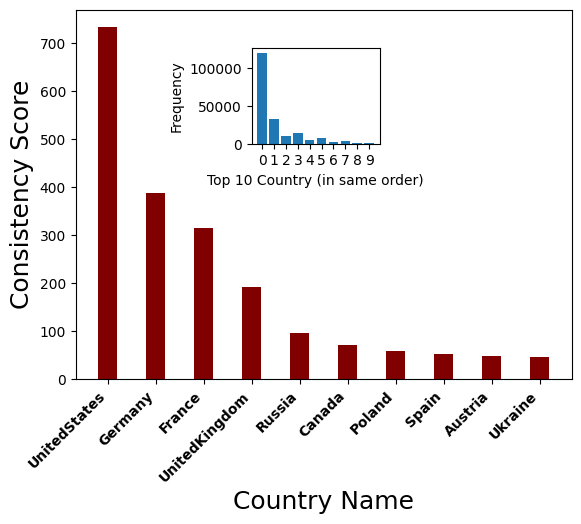

In [83]:
fontsize =  18
fig, ax1 = plt.subplots()
#fig = plt.figure(figsize = (10, 8))
# These are in unitless percentages of the figure size. (0,0 is bottom left)
left, bottom, width, height = [0.40, 0.6, 0.2, 0.2]
ax2 = fig.add_axes([left, bottom, width, height])

ax1.bar(top_countries.keys(), top_countries.values(), color ='maroon', width = 0.4)
#ax1.set_xticks(rotation=30, fontsize=fontsize-2)
ax1.set_xticklabels(top_countries.keys(), rotation=45, ha='right',weight="bold")
ax2.bar(range(len(top_population)),top_population)
ax2.set_xticks(range(len(top_population)))
ax2.set_xlabel("Top 10 Country (in same order)",fontsize=fontsize-8)
ax2.set_ylabel("Frequency", fontsize=fontsize-8)

ax1.set_xlabel("Country Name",fontsize=fontsize)
ax1.set_ylabel("Consistency Score", fontsize=fontsize)
plt.savefig(f"{fig_folder}/top_10_country.pdf",bbox_inches="tight")
#plt.title("Students enrolled in different courses")
plt.show()

In [84]:
score2[:10]

[('UnitedStates', 732.5496183206106),
 ('Germany', 388.3455497382199),
 ('France', 314.90070921985813),
 ('UnitedKingdom', 192.00746268656715),
 ('Russia', 96.99300699300699),
 ('Canada', 71.55813953488372),
 ('Poland', 58.416666666666664),
 ('Spain', 53.0),
 ('Austria', 49.603053435114504),
 ('Ukraine', 46.035714285714285)]

In [85]:
last_countries= {k:v for k, v in score2[-10:][::-1]}

In [88]:
#len(score2)

In [89]:
score2[-10:][::-1]

[("Coted'Ivoire", 0.07547169811320754),
 ('Mozambique', 0.23076923076923078),
 ('Iraq', 0.24528301886792453),
 ('Albania', 0.24528301886792453),
 ('Jamaica', 0.2692307692307692),
 ('Vietnam', 0.3018867924528302),
 ('Benin', 0.3269230769230769),
 ('Kazakhstan', 0.33962264150943394),
 ('BosniaHerzegovina', 0.7307692307692307),
 ('Philippines', 1.0192307692307692)]

In [90]:
#score2["Israel"]

In [91]:
last_population = [mgp_nodes[mgp_nodes["Country"]==k].shape[0] for k, v in last_countries.items()]

In [92]:
# fig = plt.figure(figsize = (10, 8))
# plt.bar(last_countries.keys(), last_countries.values(), color ='maroon', width = 0.4)

# plt.xticks(rotation=30,fontsize=fontsize-2)

# plt.xlabel("Country Name", fontsize=fontsize)
# plt.ylabel("Consistency Score", fontsize=fontsize)
# plt.savefig(f"{fig_folder}/last_10_country.pdf",bbox_inches="tight")
# #plt.title("Students enrolled in different courses")
# plt.show()

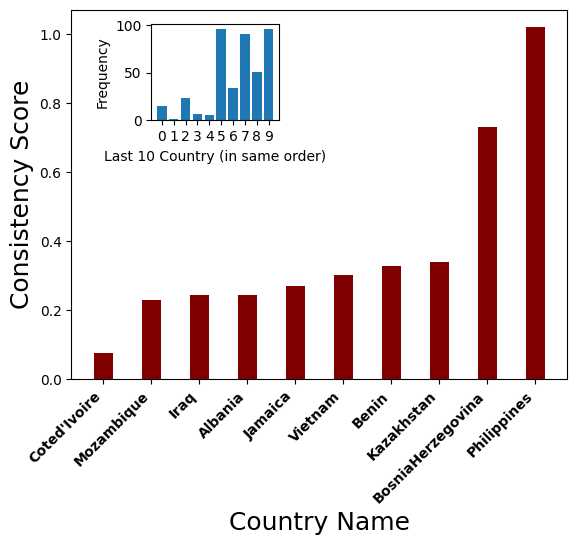

In [93]:
fig, ax1 = plt.subplots()
#fig = plt.figure(figsize = (10, 8))
# These are in unitless percentages of the figure size. (0,0 is bottom left)
left, bottom, width, height = [0.25, 0.65, 0.2, 0.2]
ax2 = fig.add_axes([left, bottom, width, height])

ax1.bar(last_countries.keys(), last_countries.values(), color ='maroon', width = 0.4)
#ax1.set_xticks(rotation=30, fontsize=fontsize-2)
ax1.set_xticklabels(last_countries.keys(), rotation=45, ha='right',weight="bold")
ax1.set_xlabel("Country Name", fontsize=fontsize)
ax1.set_ylabel("Consistency Score", fontsize=fontsize)

ax2.bar(range(len(last_population)),last_population)
ax2.set_xticks(range(len(last_population)))
ax2.set_xlabel("Last 10 Country (in same order)",fontsize=fontsize-8)
ax2.set_ylabel("Frequency", fontsize=fontsize-8)

plt.savefig(f"{fig_folder}/last_10_country.pdf",bbox_inches="tight")
#plt.title("Students enrolled in different courses")
plt.show()

### Third Approach

In [13]:
# def group_plot_metric(mgp_ids, year, metric_dist, researcher_id, name="", flag="", ylim=None):
#     if flag=="researcher":
#         txt= "MGP ID: "
#     else:
#         txt = ""
#     indexs =  [i for i, idd in enumerate(researcher_id) if idd in mgp_ids]
#     if len(indexs) > 0:
#         metric_dist = [[np.round(float(i), 2) for i in nested] for nested in metric_dist]
#         plt.figure(figsize=(8, 6), dpi=80)
#         for index in indexs:
            
#             if len(year[index][1:]) > 0:
#                 print(year[index])
#                 plt.plot(year[index][1:], metric_dist[index], label=f"{txt}{researcher_id[index]}",                             marker='o', markersize=5)
#             else:
#                 plt.plot(year[index], metric_dist[index], label=f"{txt}{researcher_id[index]}", marker='o',                     markersize=5)
#         plt.ylabel("Topic Distance Over Interval")#
#         plt.xlabel("Publication Year")
#         plt.ylim(ylim)
#         plt.legend()
#         plt.savefig(f"{fig_folder}/{name}.pdf")
#         plt.show()
#     else:
#         print(f"Advisor (Group leader : {mgp_id}) not present in the filtered dataset")
#     return

In [13]:
country, interval_start_year, norm_distance_kl, norm_distance_tau = country_wise_approach3(mgp_nodes, group_publication_titles)

In [14]:
did2 = lambda x: np.std(np.diff(x,2))*len(x)

In [15]:
did3 = lambda x:(np.std(np.diff(x,1))*np.std(x))

In [16]:
did  = lambda x: (np.std([abs(d) for d in np.diff(x,1)])*np.std(x))

In [17]:
inx = np.random.randint(0, len(norm_distance_kl))
rev = 10

In [18]:
x = norm_distance_kl[inx]
y = norm_distance_kl[inx][len(norm_distance_kl[inx])-rev:]+norm_distance_kl[inx][0:len(norm_distance_kl[inx])-rev]

In [19]:
len(x), len(y)

(27, 27)

In [20]:
did3(x), did3(y)

(0.0020280401, 0.0020555)

In [21]:
did(x), did(y)

(0.0017518003, 0.001749598)

In [22]:
np.std(x), np.std(y)

(0.041732118, 0.041732118)

In [23]:
#plt.plot(norm_distance_kl[0])

In [24]:
#plt.plot(np.diff(norm_distance_kl[0],1))

In [25]:
#did = lambda x: np.std(np.diff(x,2))*np.std(x)

In [26]:
# With modified jaccard co-efficient MJC
metric_std_tau   = [did(interval) for interval in norm_distance_tau]

# with Kullback–Leibler divergence (KL-Divergance)
metric_std_kl    = [did(interval) for interval in norm_distance_kl]

#Peaks calculation for MJC And KLD
metric_peaks_tau = [len(find_peaks(interval)[0]) for interval in norm_distance_tau]
metric_peaks_kl  = [len(find_peaks(interval)[0]) for interval in norm_distance_kl]

#set(sorted(univ_year["The country of Chicago"]))

persistent_res_kl, anti_persistent_res_kl, res_kl = find_from_filtered_top_lowest(metric_std_kl, country, zero_include=False, top=10, index_between=(0,len(country)))

persistent_res_tau, anti_persistent_res_tau, res_tau = find_from_filtered_top_lowest(metric_std_tau, country, zero_include=False, top=10, index_between=(0,len(country)))

In [27]:
norm_size = [len(a) for a in norm_distance_tau]

In [28]:
np.max(norm_size), np.min(norm_size)

(163, 6)

In [29]:
persistent_res_kl

['Germany',
 'Ireland',
 'Armenia',
 'France',
 'UnitedKingdom',
 'Croatia',
 'Sweden',
 'Netherlands',
 'Austria',
 'Czechoslovakia']

In [30]:
anti_persistent_res_kl

['Thailand',
 'Algeria',
 "Coted'Ivoire",
 'Vietnam',
 'Malaysia',
 'Iraq',
 'Iran',
 'Indonesia',
 'Benin',
 'Tunisia']

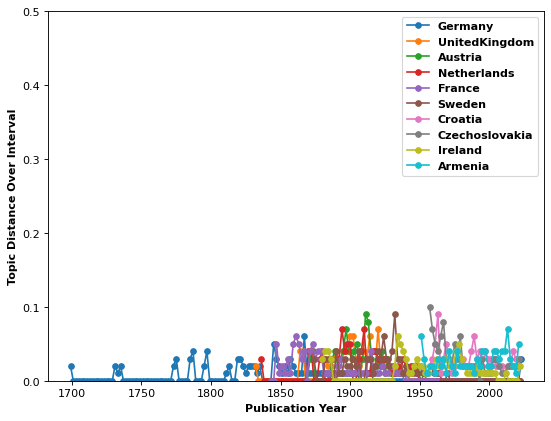

In [31]:
group_plot_metric(persistent_res_kl[:10], interval_start_year, norm_distance_kl, country, name="persistent_kl_country", ylim=(0,0.5))

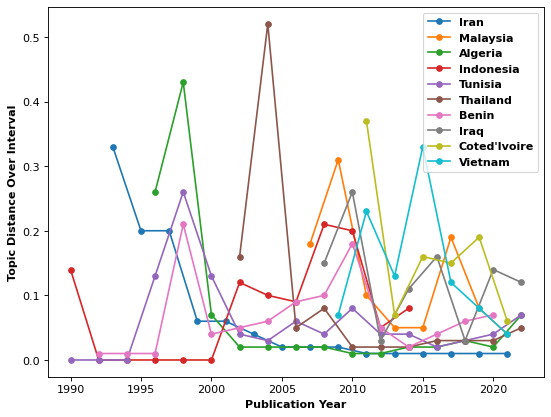

In [32]:
group_plot_metric(anti_persistent_res_kl[:10], interval_start_year, norm_distance_kl, country, name="anti_persistent_kl_country")

In [33]:
#res_kl